# Predicting LAD specialisation

**Goal**

To predict a LADs future areas of specialisation based on current specialisation. 

**Basic approach**

Train a model of specialisation gains in period t,t+1 using specialisations in period t as predictors. 

**Additions**

* Add predictors based on specialisation profile of neighbouring areas
* Expand the dataset by sampling multiple years
* Consider average distance between false predictions and actuals in the industry space

**Tasks**
* Create output and feature arrays 
* Create neightbour feature arrays
* Train model with crossvalidation using different parameters.
* Evaluate

In [401]:
#Imports

#Utilities
import os

#Numeric
import numpy as np
import pandas as pd
import itertools as itr #for cartesian product
import random #to draw random elements from list

#ml
from sklearn import preprocessing
from sklearn import multiclass, ensemble, svm, linear_model, naive_bayes
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import label_ranking_average_precision_score,average_precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Spatial
import pysal

%matplotlib inline


In [214]:
#Functions

def generate_spec_profile(path_to_nomis_download,sic_cluster_lookup):
    '''
    This function takes a nomis data download and returns a df where rows=LADs and columns=LQs in 
        #clusters based on the analysis in RCA_Pilot_Data_Collection script.
    '''
    
    #The skips and subsets are to remove some guff
    idbr_sic_lad = pd.read_csv(path_to_nomis_download,skiprows=8,header=0)
    idbr_sic_lad = idbr_sic_lad.ix[:405,:]
    
    
    idbr_sic_lad.rename(columns={'local authority: district / unitary (prior to April 2015)':'lad_name',
                                     'mnemonic':'lad_code'},inplace=True)

    #Melt and create sic_4 variable to merg with clusters
    idbr_sic_lad_long = pd.melt(idbr_sic_lad,id_vars=['lad_name','lad_code'])
    idbr_sic_lad_long['sic_4_l'] = idbr_sic_lad_long['variable'].apply(lambda x:
                                                                          x.split(":")[0].strip())

    lad_clusters = pd.merge(idbr_sic_lad_long,sic_cluster_lookup,
                               left_on='sic_4_l',right_on='sic_4_string',how='inner')
    
    #Aggregate level of activity over clusters
    lad_clusters_counts = pd.pivot_table(lad_clusters,
                        index='lad_name',columns=['label'],values='value',aggfunc=np.sum,fill_value=0)
    lad_clusters_counts.reset_index(drop=False,inplace=True)

    #Create a DF with LQs
    area_shares = lad_clusters_counts.sum(axis=1)/np.sum(lad_clusters_counts.sum(axis=1))

    lad_clusters_lqs = pd.concat([lad_clusters_counts['lad_name'],
                                   lad_clusters_counts.ix[:,1:].apply(lambda x: (x/x.sum())/area_shares,axis=0)],
                                  axis=1)
    
    return(lad_clusters_lqs)
    
def become_specialised(spec_df_period_1,spec_df_period_2):
    '''
    Returns a df measuring change between two periods.
    If definition =1 means that the binary is 1=became specialised, 0=didn't
    '''
    
    ch = spec_df_period_2 - spec_df_period_1
    out = ch.applymap(lambda x: 0 if x<0 else x)
    return(out)
    
def gain_specialisation(clustering_period_1,clustering_period_2,threshold=0.2):
    '''
    Returns a df measuring change in specialisation between 2 periods
    If definition =1 means that the binary is 1=became specialised, 0=didn't
    '''
    
    ch = clustering_period_2.ix[:,1:]/clustering_period_1.ix[:,1:]
    out = ch.applymap(lambda x: 1 if x-1>threshold else 0)
    return(out)

    
    

## 1. Load and process

In [241]:
#Set path for idbr file and load lookup
sic_cluster_lookup = pd.read_csv("../industry/intermediate_outputs/clusters_64_labelled.csv",
                                encoding = "ISO-8859-1")
#NB we need to create a sic string in some cases starting with 0
sic_cluster_lookup['sic_4_string'] = [
    "0"+str(x) if len(str(x))<4 else str(x) for x in sic_cluster_lookup.sic_4]

#Extract the LQs for the period 2011-2015 (NB we lose the lad name column, which isn't of interest)
cluster_lqs = [generate_spec_profile('../industry/data_input/idbr_lad_{y}.csv'.format(y=str(x)),
                                    sic_cluster_lookup) for x in range(2010,2016)]

#Create dummy dfs (1 if a LAD is specialised in an area, 0 if not) 
#(NB we lose the lad name column, which isn't of interest)
binary_spec_lqs = [x.ix[:,1:].applymap(lambda x: 1 if x>1 else 0) for x in cluster_lqs]

#Create lad and sect vars for indexing dfs and columns later
lad_set = cluster_lqs[0].ix[:,0]
sector_set = binary_spec_lqs[0].columns

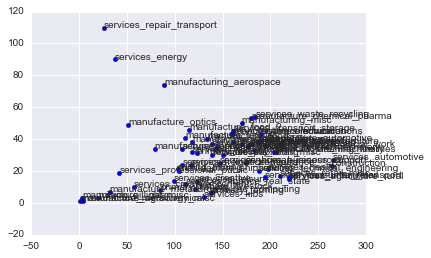

In [243]:
#Consider changes in specialisation between periods
specialise_2011_2015 = become_specialised(binary_spec_lqs[0],binary_spec_lqs[5])

plt.scatter(binary_spec_lqs[0].sum(),specialise_2011_2015.sum())

for n, (x,y) in enumerate(zip(binary_spec_lqs[0].sum(),specialise_2011_2015.sum())):
    plt.annotate(xy=(x,y),s=binary_spec_lqs[0].sum().index[n])

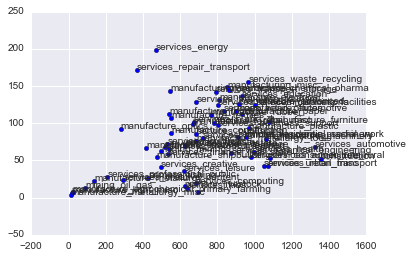

In [251]:
#Let's see what it looks like if we concatenate year-on-year changes 

yoy_changes = pd.concat([change_between_periods(x,y) for x,y in zip(binary_spec_lqs[:-1],
                                                                   binary_spec_lqs[1:])]) 
yoy_specs = pd.concat(binary_spec_lqs[:-1])                    

#Seems to address some of the outliers
plt.scatter(yoy_specs.sum(),yoy_changes.sum())

for n, (x,y) in enumerate(zip(yoy_specs.sum(),yoy_changes.sum())):
    plt.annotate(xy=(x,y),s=yoy_specs.sum().index[n])

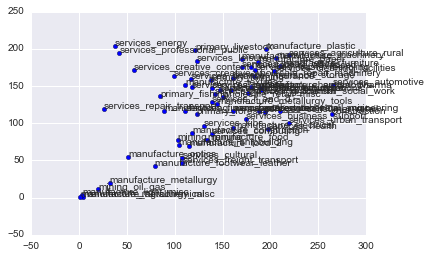

In [264]:
#Let's replicate with gains in specialisation
gain_specialisation_2011_2015 = gain_specialisation(cluster_lqs[0],cluster_lqs[5],threshold=0.05)

plt.scatter(binary_spec_lqs[0].sum(),gain_specialisation_2011_2015.sum())

for n, (x,y) in enumerate(zip(binary_spec_lqs[0].sum(),gain_specialisation_2011_2015.sum())):
    plt.annotate(xy=(x,y),s=binary_spec_lqs[0].sum().index[n])


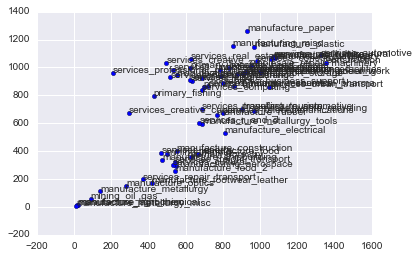

In [354]:
#And again, aggregating over years

yoy_gains = pd.concat([gain_specialisation(x,y,threshold=0) for x,y in zip(cluster_lqs[:-1],
                                                                   cluster_lqs[1:])]) 

yoy_specs = pd.concat(binary_spec_lqs[:-1])

#yoy_specs_2 considers the actual location quotients in the area
yoy_specs_2 = pd.concat([x.ix[:,1:] for x in cluster_lqs[:-1]])

#Seems to address some of the outliers
plt.scatter(yoy_specs.sum(),yoy_gains.sum())

for n, (x,y) in enumerate(zip(yoy_specs.sum(),yoy_gains.sum())):
    plt.annotate(xy=(x,y),s=yoy_specs.sum().index[n])

## 2. Model

In [160]:
#Strategy
#Select 3 models:
    #Logistic regression
    #Naive bayes
    #Random forests
#Consider parameters to tune in each of the models, and do it. Graph changes in performance.
#Add neighbor activity variables; re-run models and consider changes in performance.

#Run a neural net.

In [425]:
#Create input and output
X = np.array(yoy_specs_2)
Y = np.array(yoy_gains)

#Set number of cross validation folds
cv = 3

#Initialise a random forests classifier
rf_clf = multiclass.OneVsRestClassifier(ensemble.RandomForestClassifier(max_depth=5))

#Define the scorer
aps = make_scorer(recall_score,average='macro')

#Estimate scores
rf_scores = cross_validation.cross_val_score(rf_clf,X=X,y=Y,
                                             scoring=aps,cv=cv)


In [441]:
out = pd.DataFrame(rf_clf.fit(X,Y).predict(binary_spec_lqs[5]),index=lad_set,columns=sector_set)

In [444]:
out.ix['Leeds'].sort_values(ascending=False)[1:10]

services_retail_misc                1
services_health                     1
manufacture_paper                   1
manufacture_plastic                 1
services_professional_public        1
manufacture_metallurgy_tools        1
services_residential_social_work    1
services_head_offices               1
manufacturing_misc                  1
Name: Leeds, dtype: int64